In [1]:
from shapely.geometry import Polygon
from scipy.integrate import simps
import numpy as np
import os
import laspy
import pandas as pd
from scipy.integrate import trapz
from scipy.spatial import ConvexHull, Delaunay
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from alphashape import alphashape
import matplotlib.patches as patches
from scipy.interpolate import griddata
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
import time
from sklearn.cluster import DBSCAN
import pyproj

In [2]:
directory = os.getcwd()
directory

'c:\\Users\\tttajude\\MScResearch\\MainFiles'

In [3]:
infile = os.path.join(directory, "OriginalData", "visualisationb2.las")
#infile = os.path.join(directory, "OriginalData", "Knee1a2a.las")
las_fil = laspy.read(infile)
#las_fil = laspy.read("C:\\Users\\tttajude\\Research\\imagecontest1.las")
#las_fil = laspy.read("C:\\Users\\tttajude\\Research\\OriginalData\\visualisationb.las")
#las_fil = laspy.read("C:\\Users\\tttajude\\Research\\OriginalData\\point_define4ka5a.las")

In [4]:
#print(lidar_data.columns)
dimension = list(las_fil.point_format.dimension_names)
print(dimension)

['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'synthetic', 'key_point', 'withheld', 'scan_angle_rank', 'user_data', 'point_source_id', 'red', 'green', 'blue']


In [5]:
# Define the coordinate system
crs = pyproj.CRS.from_epsg(32617) #6543, 4326
las_fil.header.srs = pyproj.CRS.from_epsg(32617).to_wkt()

In [6]:
# Create a grid that covers the entire area of the stockpile
#x_min, y_min, z_min, x_max, y_max, z_max = las_file.get_header()
xi = las_fil.x
yi = las_fil.y
zi = las_fil.z

# Print the summary of x, y, and z values
print("Summary of X values:")
print(f"  Minimum: {np.min(xi)}")
print(f"  Maximum: {np.max(xi)}")
print("")

print("Summary of Y values:")
print(f"  Minimum: {np.min(yi)}")
print(f"  Maximum: {np.max(yi)}")
#print(f"  Mean: {np.mean(y_points)}")
#print(f"  Median: {np.median(y_points)}")
#print(f"  Standard Deviation: {np.std(y_points)}")
print("")

print("Summary of Z values:")
print(f"  Minimum: {np.min(zi)}")
print(f"  Maximum: {np.max(zi)}")
print("")

Summary of X values:
  Minimum: 752705.863
  Maximum: 752706.462

Summary of Y values:
  Minimum: 3820839.562
  Maximum: 3820839.959

Summary of Z values:
  Minimum: 0.34600000000000003
  Maximum: 1.241



In [7]:
# Select only points classified as non-ground points (class code 0)
las_file = las_fil.points[las_fil.classification == 0]

# get the x, y, and z coordinates of the points
x = las_file.x
y = las_file.y
z = las_file.z

In [8]:
#convert las lidar points to numpy array
points = np.vstack((las_file.x, las_file.y, las_file.z)).transpose() 
print(f"Number of points: {points.shape[0]}")

Number of points: 7617


In [9]:
# Find the minimum and maximum values for each dimension
min_x, max_x = las_file.x.min(), las_file.x.max()
min_y, max_y = las_file.y.min(), las_file.y.max()
min_z, max_z = las_file.z.min(), las_file.z.max()

##### Point Cloud Segmentation using DBSCAN (Density-Based Spatial Clustering of Applications with Noise) 
It is a clustering algorithm used in machine learning and data mining. Unlike k-means, which requires the number of clusters to be specified in advance, DBSCAN is able to automatically determine the number of clusters based on the data.
DBSCAN works by grouping together data points that are close to each other in a high-dimensional space. It defines clusters as dense regions of points that are separated by regions of lower point density, and can also identify noise points that don't belong to any cluster.
To accomplish this, DBSCAN uses two main parameters: "epsilon" and "min_samples". Epsilon determines the maximum distance between two points for them to be considered neighbors, while min_samples sets the minimum number of points that must be within epsilon distance of a point for it to be considered a core point.
The algorithm works by first selecting a random unvisited point and expanding a cluster around it by finding all its neighbors within epsilon distance. If the number of neighbors is greater than or equal to min_samples, the point is considered a core point and all its neighbors are added to the cluster. This process continues recursively until no more points can be added to the cluster. The algorithm then selects another unvisited point and repeats the process until all points have been visited.
Any points that are not included in any cluster are considered noise points. DBSCAN is able to identify clusters of arbitrary shape and can handle outliers and noise points well, making it a popular algorithm for data clustering.

In [10]:
# Perform clustering on the non-ground points
dbscan = DBSCAN(eps=0.05, min_samples=10)
#dbscan = DBSCAN(eps=0.05, min_samples=10)
#labels = dbscan.fit_predict(points)
labels = dbscan.fit_predict(np.column_stack((x, y, z)))

# get the number of clusters
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)      
print("Number of knees identified:", num_clusters)

Number of knees identified: 1


### 1. Convex Hull by Slicing Algorithm

In [11]:
start_time = time.time()   # Start the timer
slice_height = 0.02   # Define the slicing height

# Loop over the clusters
for i in range(num_clusters):
    # Get the points belonging to this cluster
    cluster_points = np.where(labels == i)[0]

    # Calculate the convex hull of the cluster
    cluster_hull = ConvexHull(np.column_stack((x[cluster_points], y[cluster_points], z[cluster_points])))

    # Get the minimum and maximum z coordinates of the cluster
    min_z = np.min(z[cluster_points])
    max_z = np.max(z[cluster_points])
    height = max_z - min_z
    print (height)

    # Create a list of slicing heights
    slice_heights = np.arange(min_z, max_z + slice_height, slice_height)

    # Initialize the volume and last_area
    volume = 0.0
    last_area = 0.0

    # Slice the convex hull at each slicing height
    for j in range(len(slice_heights) - 1):
        # Select the points within the slicing height
        mask = (cluster_hull.points[:, 2] >= slice_heights[j]) & (cluster_hull.points[:, 2] < slice_heights[j+1])
        points = cluster_hull.points[mask, :2]
        
        # Check if there are enough points to compute the convex hull
        if len(points) < 3:
            continue

        # Calculate the area of the slice
        area = ConvexHull(points).volume
        #area = hull.area

        # Integrate the area to calculate the volume of this slice
        slice_volume = slice_height * (area + last_area) / 2
        #slice_volume = slice_height * area
        
        volume += slice_volume

        # Save the current area for the next iteration
        last_area = area
        #print(volume)
        
        #Calculate the convex hull of the slice
        slice_hull = ConvexHull(points)

        # Plot the slice
        '''
        plt.figure()
        plt.scatter(points[:, 0], points[:, 1])
        plt.plot(points[slice_hull.vertices, 0], points[slice_hull.vertices, 1], 'r--', lw=2)
        #plt.title(f"Knee {i+1}, Slice {j+1}")
        plt.title(f"Knee {i+1}, Slice at height {slice_heights[j]:.2f}")
        #plt.title(f"Knee {i+1}, Slice at height 0.40")
        plt.xlabel("X(m)")
        plt.ylabel("Y(m)")
        plt.show()
        '''

    # Print the volume of this cluster
    print(f"Volume {i+1}: {volume:.5f} cubic units")
    #print(f"{volume:.5f}")


end_time = time.time() # End the timer
elapsed_time = end_time - start_time # Calculate the elapsed time
print("Elapsed time: {:.2f} seconds".format(elapsed_time)) # Print the elapsed time

0.8390000000000001
Volume 1: 0.01135 cubic units
Elapsed time: 0.02 seconds


### Create a function for volume estimation and for generating geometric shape

In [12]:
#Define the slicing heights
slicing_heights = [0.2, 0.1, 0.05, 0.02]

In [13]:
# Function to calculate volume for a given slicing height
def calculate_volume(labels, x, y, z, num_clusters, slice_height, ax):
    # Loop over the clusters
    
    volumes = []
    for i in range(num_clusters):
        # Get the points belonging to this cluster
        cluster_points = np.where(labels == i)[0]
        cluster_x = x[cluster_points]
        cluster_y = y[cluster_points]
        cluster_z = z[cluster_points]

        # Calculate the convex hull of the cluster
        cluster_hull = ConvexHull(np.column_stack((x[cluster_points], y[cluster_points], z[cluster_points])))

        # Get the minimum and maximum z coordinates of the cluster
        min_z = np.min(z[cluster_points])
        max_z = np.max(z[cluster_points])
        
        # Include special slicing height "max_z"
        if isinstance(slice_height, str) and slice_height.lower() == "max_z":
            slice_height = max_z

        # Create a list of slicing heights
        slice_heights = np.arange(min_z, max_z + slice_height, slice_height)

        # Initialize the volume and last_area
        volume = 0.0
        last_area = 0.0

        # Slice the convex hull at each slicing height
        for j in range(len(slice_heights) - 1):
            # Select the points within the slicing height
            mask = (cluster_hull.points[:, 2] >= slice_heights[j]) & (cluster_hull.points[:, 2] < slice_heights[j+1])
            points = cluster_hull.points[mask, :]

            # Check if there are enough points to compute the convex hull
            if len(points) < 3:
                continue

            # Calculate the convex hull of the slice
            slice_hull = ConvexHull(points)
            

            # Plot the convex hull slice in 3D and color it by the assigned color
            #cmap='Accent'
            #color = cmap
            color = cmap(j)
            
            ax.plot_trisurf(points[:, 0], points[:, 1], points[:, 2], triangles=slice_hull.simplices,
                            color=color, alpha=0.4)

            # Calculate the area of the slice
            area = slice_hull.volume

            # Integrate the area to calculate the volume of this slice
            slice_volume = slice_height * (area + last_area) / 2
            volume += slice_volume

            # Save the current area for the next iteration
            last_area = area
        
        volumes.append(volume)
    
    return volumes

### For visualization

In [14]:
def return_first(num_clusters):
    for i in range(num_clusters):
        if np.any(labels == i):
            cluster_points = np.where(labels == i)[0][0]
            cluster_x = x[cluster_points]
            cluster_y = y[cluster_points]
            cluster_z = z[cluster_points]
            return cluster_x, cluster_y, cluster_z
        
# Get the indices of points belonging to the first cluster
first_cluster_indices = np.where(labels == 0)[0]

# Extract points of the first cluster
x1 = x[first_cluster_indices]
y1 = y[first_cluster_indices]
z1 = z[first_cluster_indices]

In [15]:
# Parameters for the conical geometry
radius = 0.1024
height = 0.902

# Calculate centroid of the point cloud
centroid = np.mean(np.vstack((x1, y1, z1)), axis=1)

# Calculate the minimum z-coordinate of the point cloud
min_z_cloud = np.min(z1)

# Calculate the z-coordinate of the cone's base
z_base_cone = min_z_cloud

# Create meshgrid for the conical surface
theta_mesh = np.linspace(0, 2*np.pi, 100)
z_mesh = np.linspace(0, height, 100)
theta_mesh, z_mesh = np.meshgrid(theta_mesh, z_mesh)

# Compute coordinates of the conical surface centered at the centroid
x_cone = centroid[0] + radius * (1 - z_mesh/height) * np.cos(theta_mesh)
y_cone = centroid[1] + radius * (1 - z_mesh/height) * np.sin(theta_mesh)
z_cone = z_base_cone + z_mesh  # Align the base of the cone with the minimum z-coordinate of the point cloud

In [16]:
# Define the gradient colors for the colormap # Create the custom colormap
#colors = [(0.0, 'blue'), (0.3111, 'green'), (0.645555, 'yellow'), (1.0, 'red')]
colors = [(0.0, 'brown'), (0.2566, 'green'), (0.345555, 'yellow'), (0.6111, 'brown'), (1.0, 'red')]
cmap1 = LinearSegmentedColormap.from_list('gradient', colors)

# Define slicing heights
slicing_heights = [0.2, 0.1, 0.05, 0.02]

# Create a custom colormap with a fixed number of color # Create a color map for each slicing heights
num_slices = len(slice_heights) - 1
cmap = plt.get_cmap('tab10', num_slices)

C:\Users\tttajude\AppData\Local\Temp\ipykernel_24800\1833031669.py:27: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  artists = legend.legendHandles
C:\Users\tttajude\AppData\Local\Temp\ipykernel_24800\1833031669.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\tttajude\AppData\Local\Temp\ipykernel_24800\1833031669.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\tttajude\AppData\Local\Temp\ipykernel_24800\1833031669.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(a

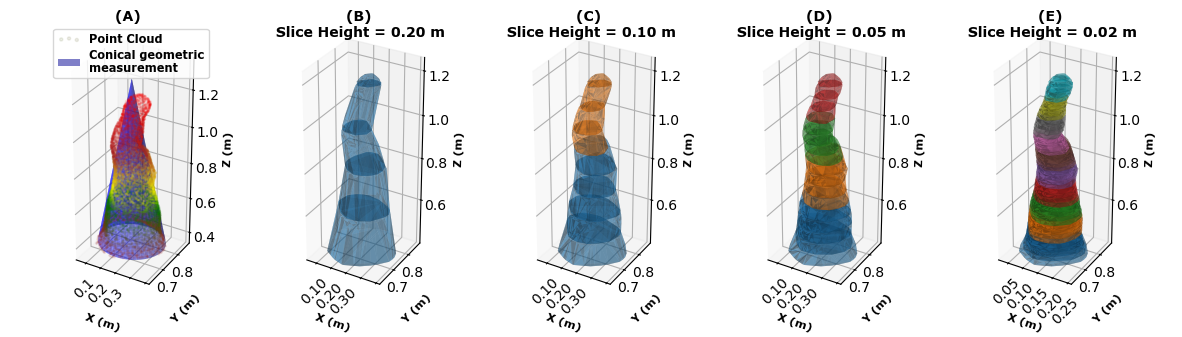

In [17]:
# Create subplots for each slicing height
fig, axs = plt.subplots(1, len(slicing_heights) + 1, figsize=(15, 5), subplot_kw={'projection': '3d'})

# Scatter plot of the original point cloud
scatter = axs[0].scatter(x, y, z, c=z, cmap=cmap1, s=1, marker='o', alpha=0.1, label = 'Point Cloud')
axs[0].plot_surface(x_cone, y_cone, z_cone, color='b', alpha=0.5, label='Conical geometric\nmeasurement')
axs[0].set_xlabel('X (m)', fontsize=8, fontdict={'family': 'Verdana', 'weight': 'bold'}, labelpad = 0)
axs[0].set_ylabel('Y (m)', fontsize=8, fontdict={'family': 'Verdana', 'weight': 'bold'}, labelpad = 0)
axs[0].set_zlabel('Z (m)', fontsize=8, fontdict={'family': 'Verdana', 'weight': 'bold'}, labelpad = 8)
axs[0].autoscale(enable=True, axis='both')
axs[0].set_box_aspect([1, 1, 2.5])  # Adjust the aspect ratio of the plot
axs[0].set_title("(A) \n ", fontsize=10, fontdict={'family': 'Verdana', 'weight': 'bold'})

axs[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.1f}'.format(x % 1)))
axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1f}'.format(y % 1)))

legend = axs[0].legend(loc='upper right', fontsize=8, bbox_to_anchor=(0.85, 1.09), scatterpoints=3)

leg = axs[0].get_legend()
    
for text in leg.get_texts():
    text.set_fontfamily('Verdana')
    text.set_weight('bold')
    text.set_fontsize(8.2)

# Get the artists in the legend
artists = legend.legendHandles

# Set the marker size for the scatter points in the legend
for artist in artists:
    artist._sizes = [5]

num = ["(B)", "(C)", "(D)", "(E)"]

# Loop over each slicing height
for i, (slicing_height, b) in enumerate(zip(slicing_heights, num)):
    # Calculate volume and plot for each slicing height
    calculate_volume(labels, x, y, z, num_clusters, slicing_height, axs[i + 1])
    
    for ax in axs:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        #ax.set_yticklabels(ax.get_yticklabels(), rotation=1)
        ax.tick_params(axis='x', which='major', pad=-3)
        ax.tick_params(axis='y', which='major', pad=-3)
    
    # Set labels and title
    axs[i + 1].set_xlabel('X (m)', fontsize=8, fontdict={'family': 'Verdana', 'weight': 'bold'}, labelpad = 0)
    axs[i + 1].set_ylabel('Y (m)', fontsize=8, fontdict={'family': 'Verdana', 'weight': 'bold'}, labelpad = 0)
    axs[i + 1].set_zlabel('Z (m)', fontsize=8, fontdict={'family': 'Verdana', 'weight': 'bold'}, labelpad = 8)
    axs[i + 1].set_title(f'{b} \nSlice Height = {slicing_height:.2f} m', fontsize=10, fontdict={'family': 'Verdana', 'weight': 'bold'})
    #axs[i + 1].set_title(f'{b} \nSlice Height = {round(slicing_height * 100)} cm', fontsize=10, fontdict={'family': 'Verdana', 'weight': 'bold'})
    axs[i + 1].autoscale(enable=True, axis='both')
    axs[i + 1].set_box_aspect([1, 1, 2.5])  # Adjust the aspect ratio of the plot
    
    axs[i + 1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.2f}'.format(x % 1)))
    axs[i + 1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.1f}'.format(y % 1)))

plt.subplots_adjust(wspace=-.04, hspace=0) # Adjust the spacing between subplots
plt.tight_layout()   # Show the plot
plt.savefig(f"cluster_plot34.png", dpi=300)
plt.show()

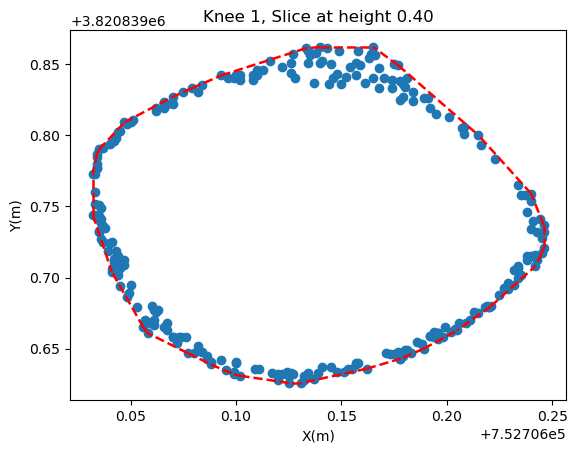

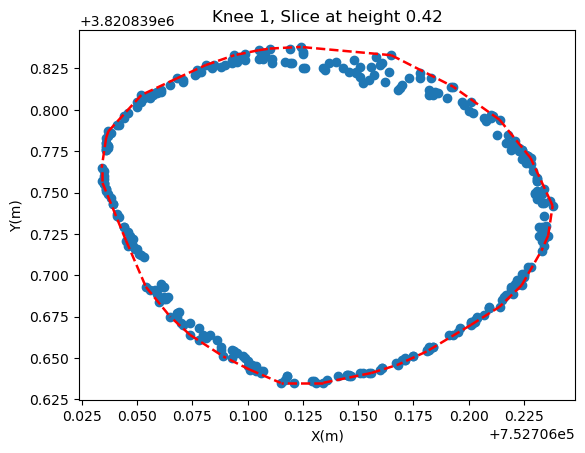

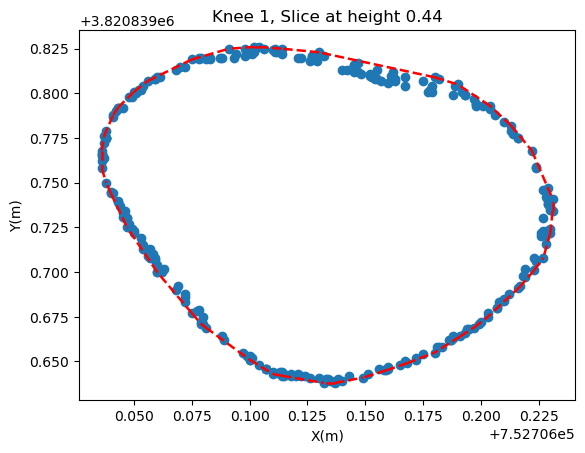

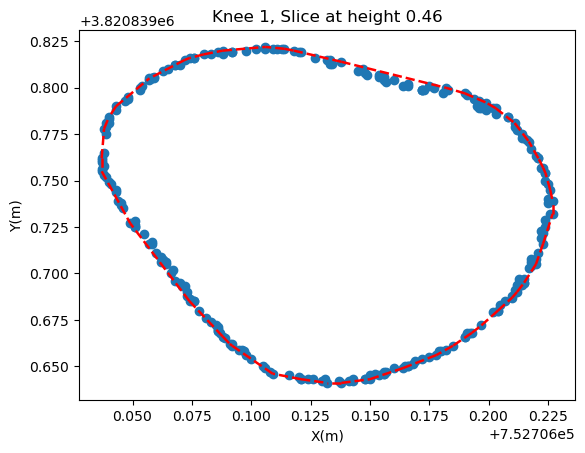

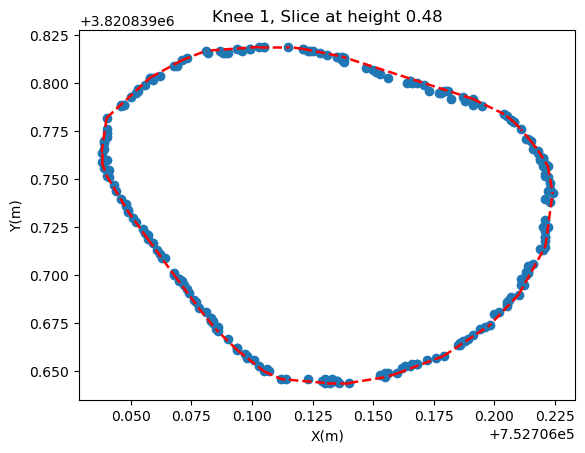

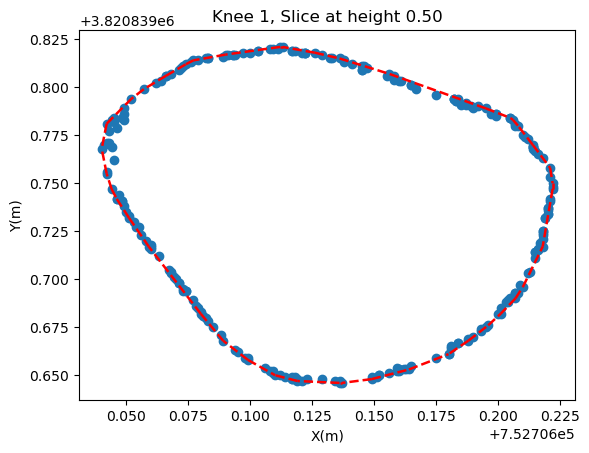

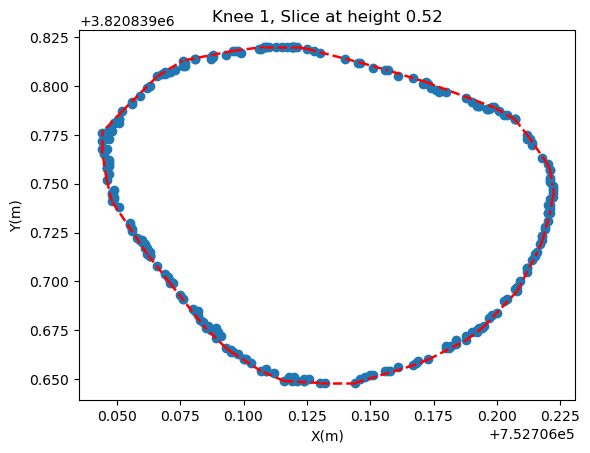

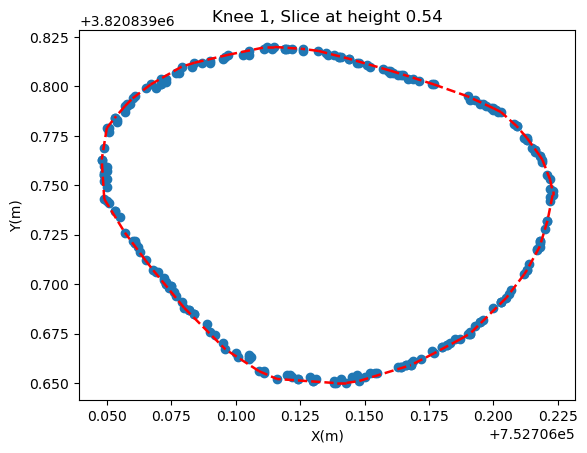

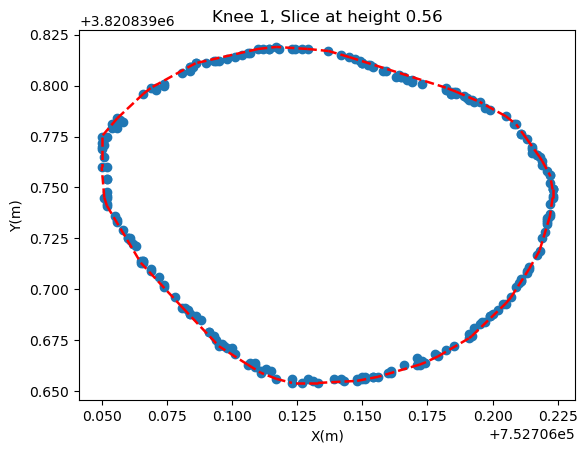

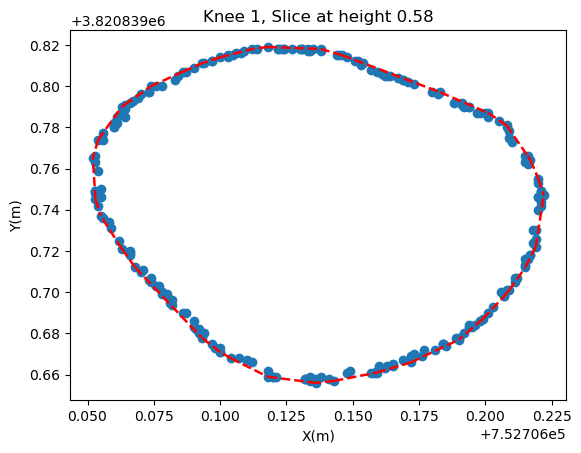

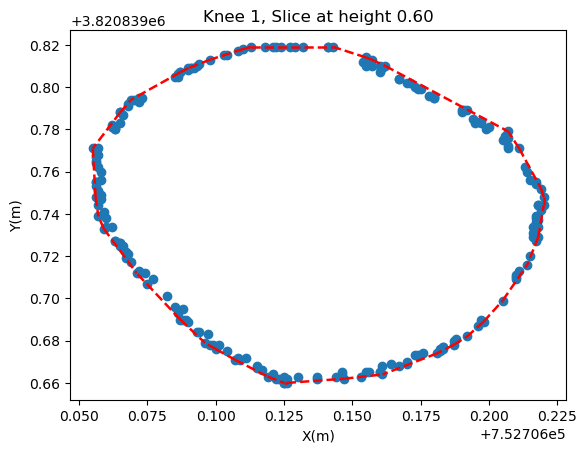

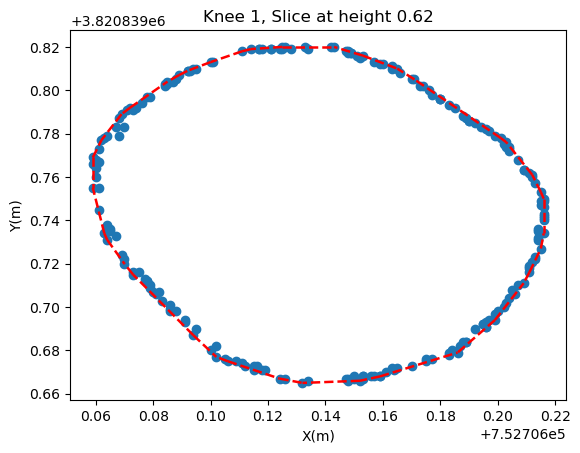

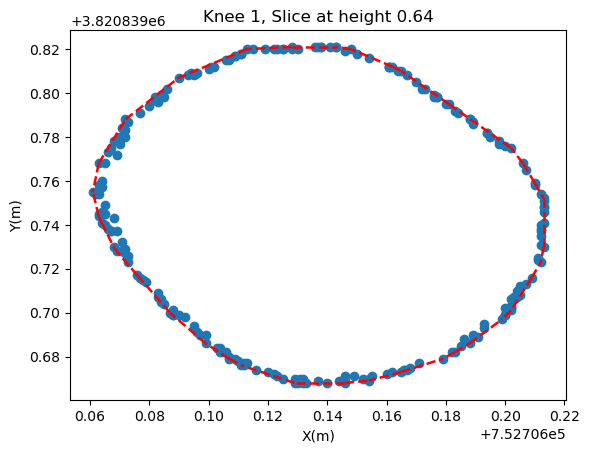

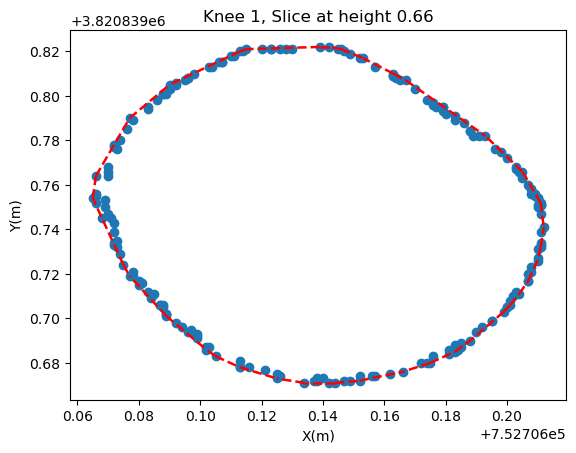

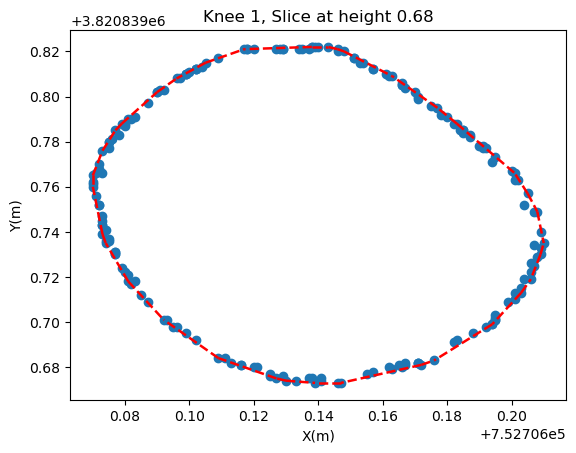

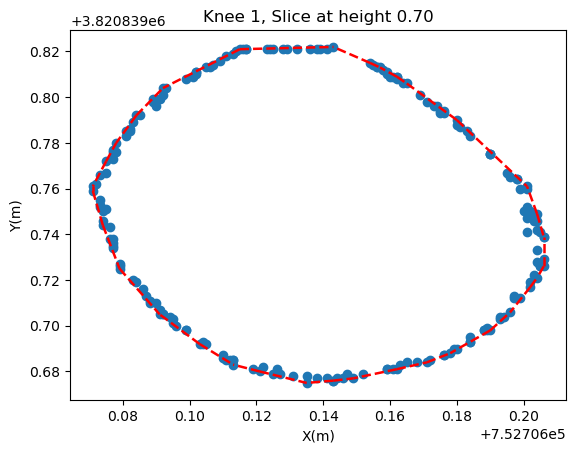

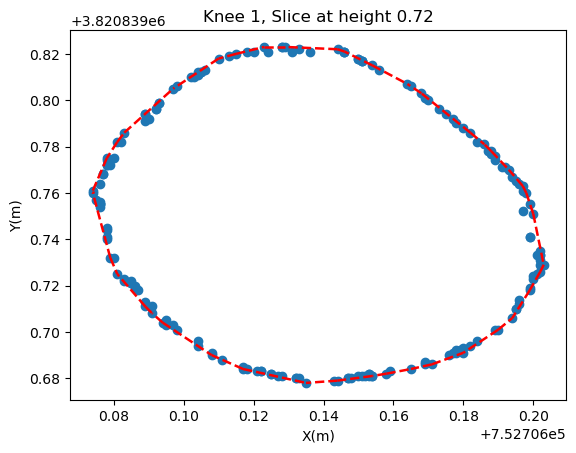

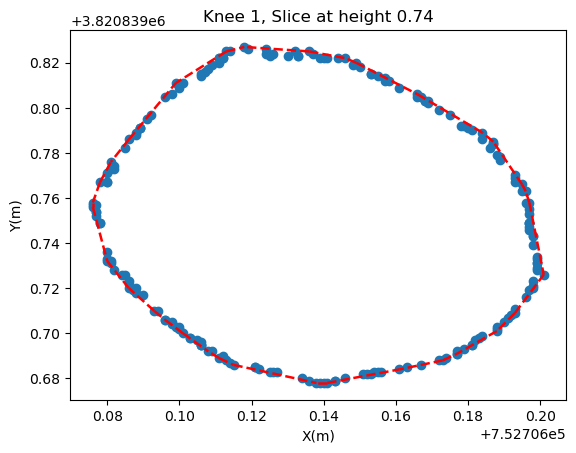

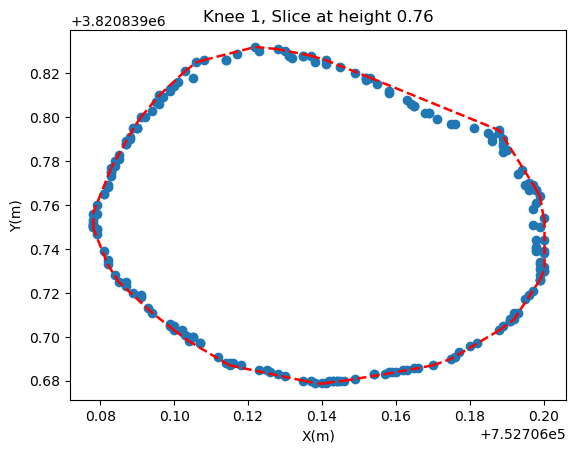

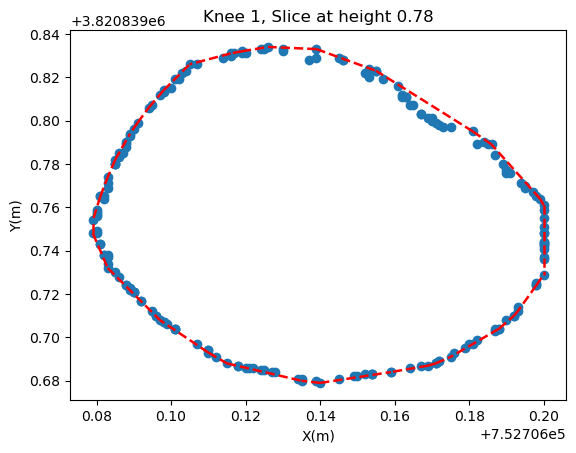

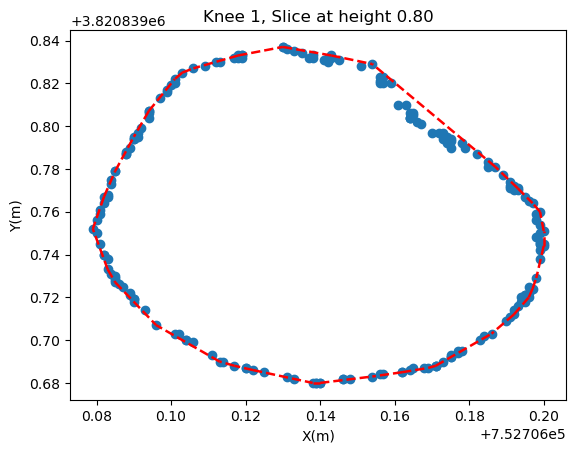

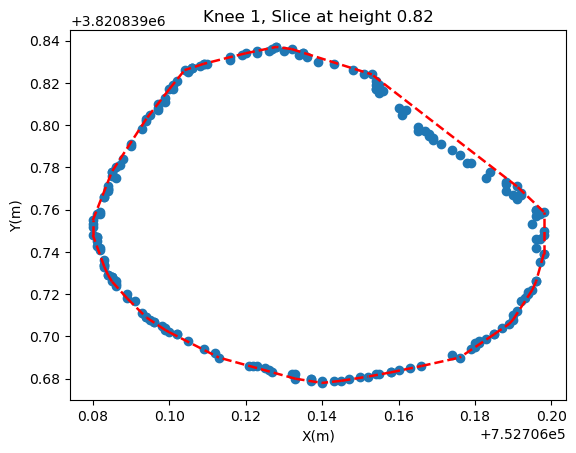

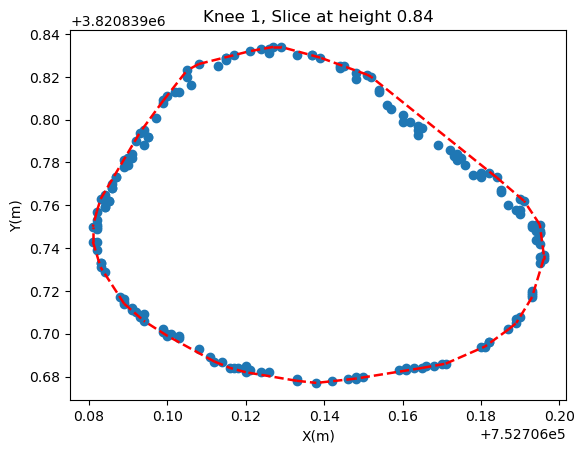

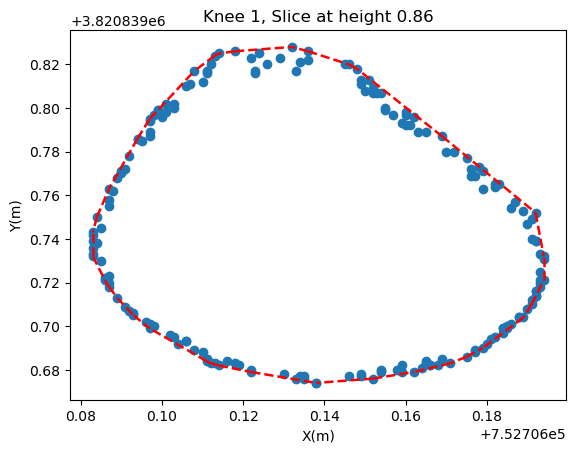

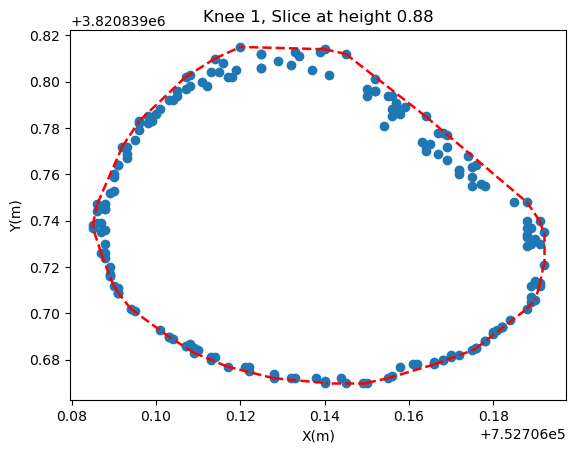

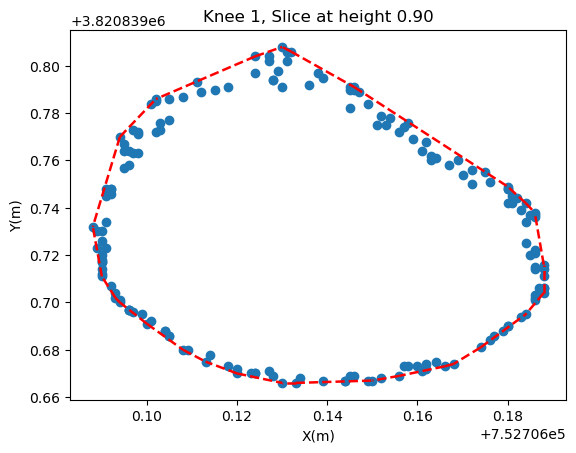

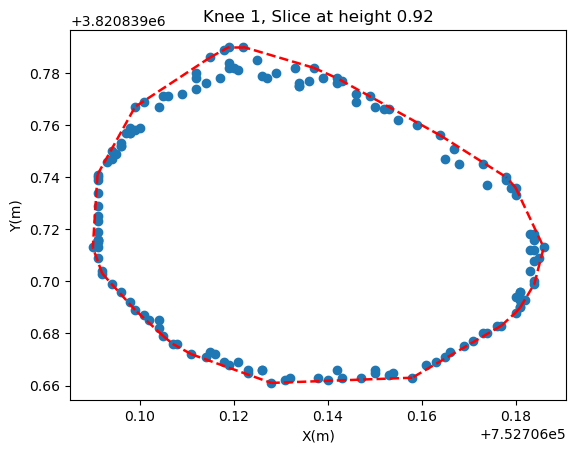

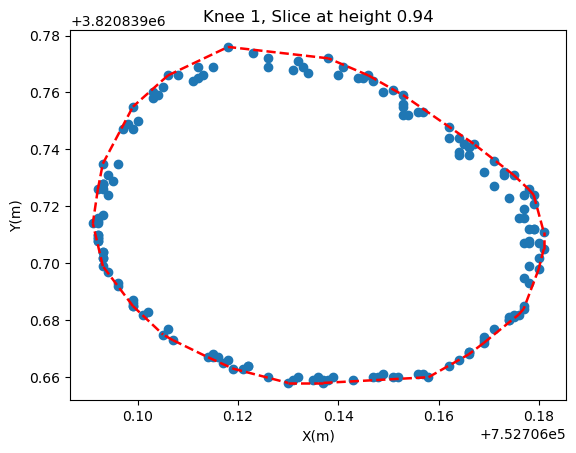

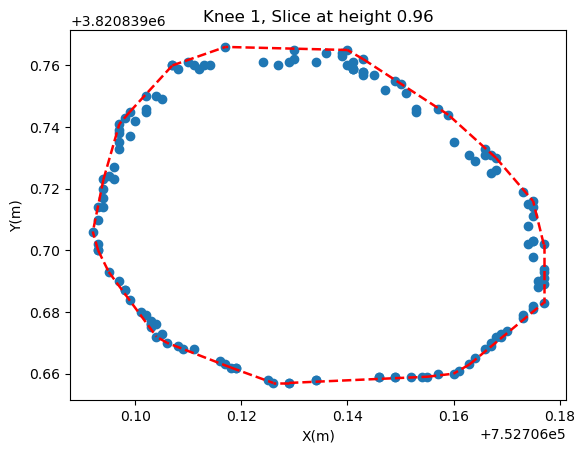

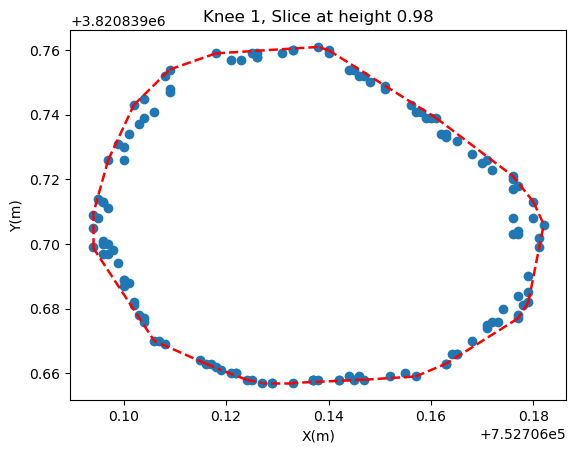

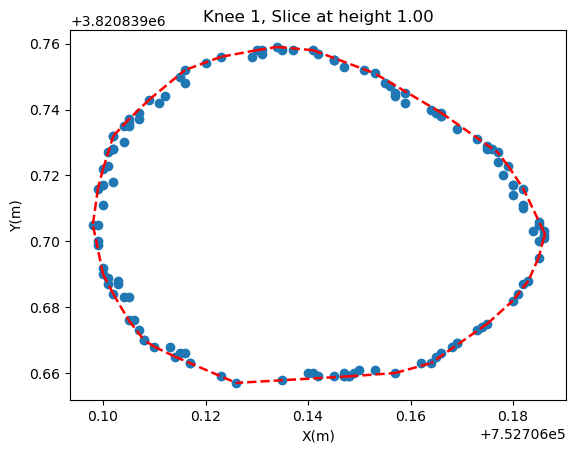

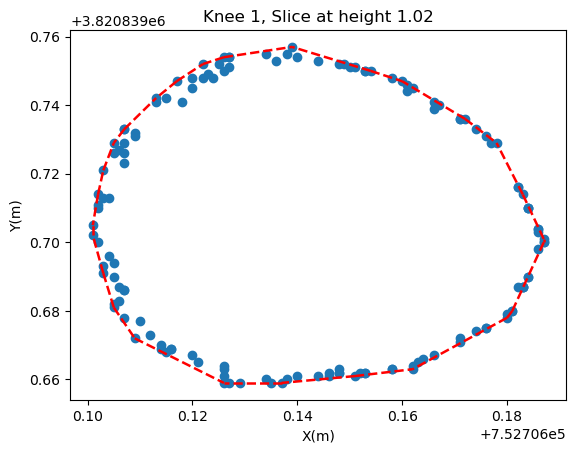

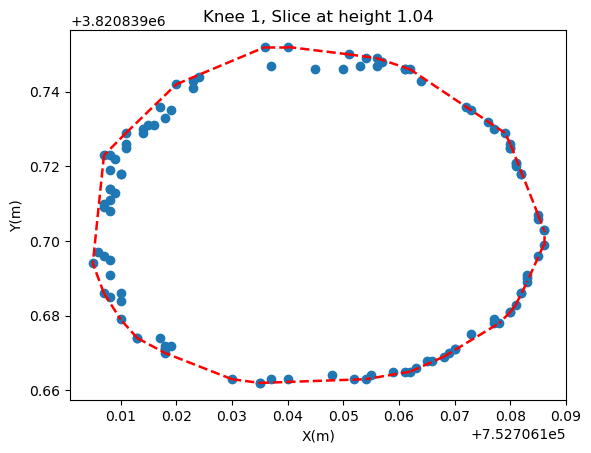

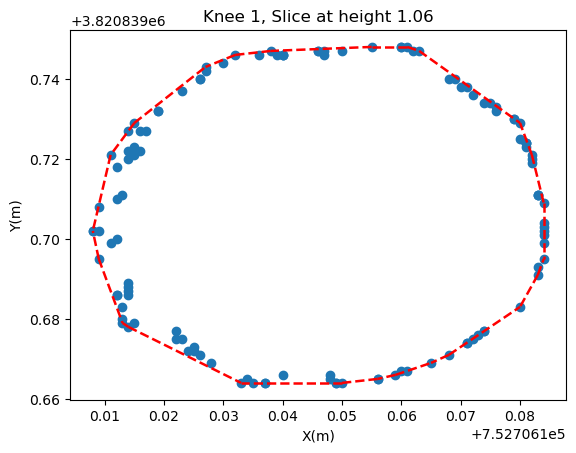

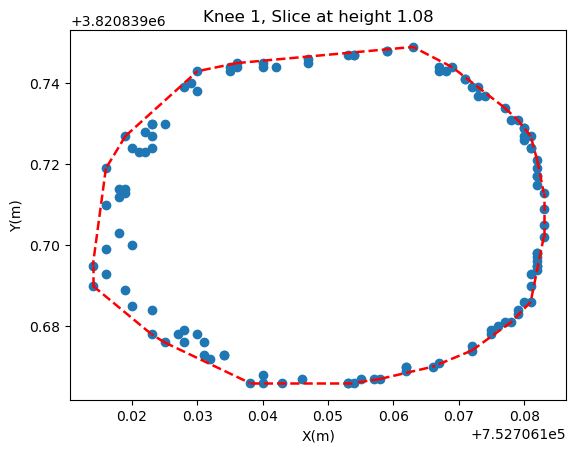

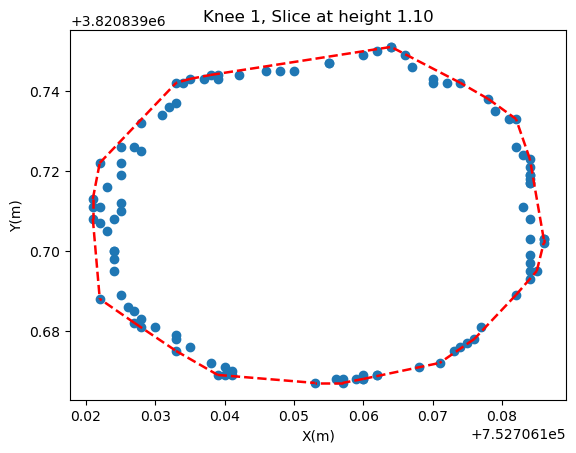

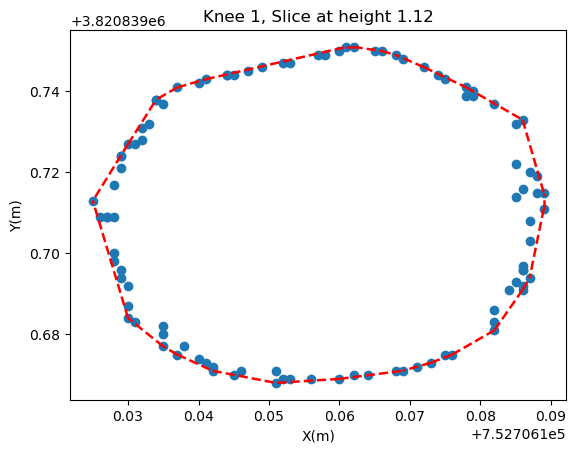

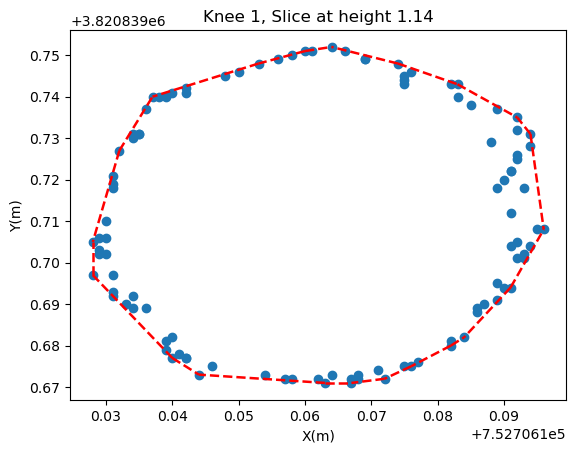

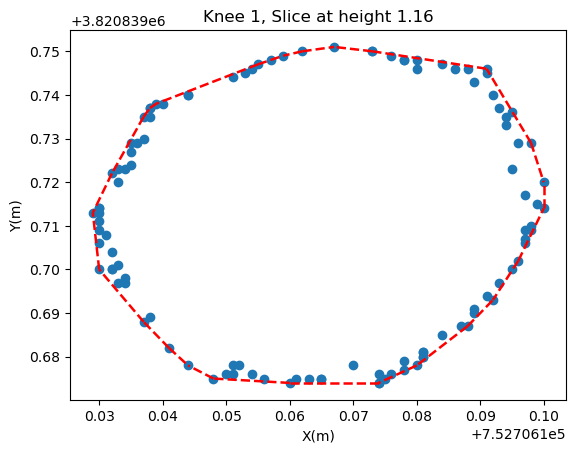

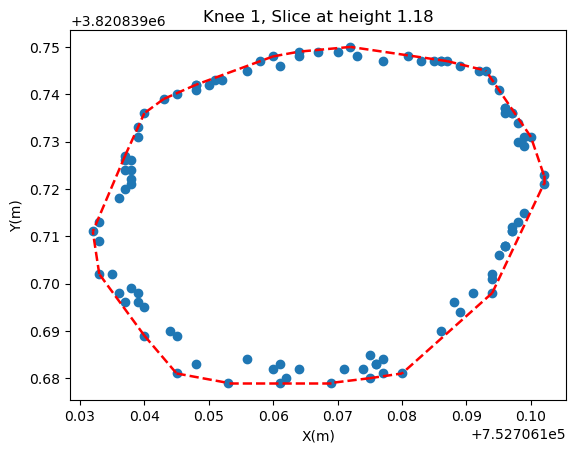

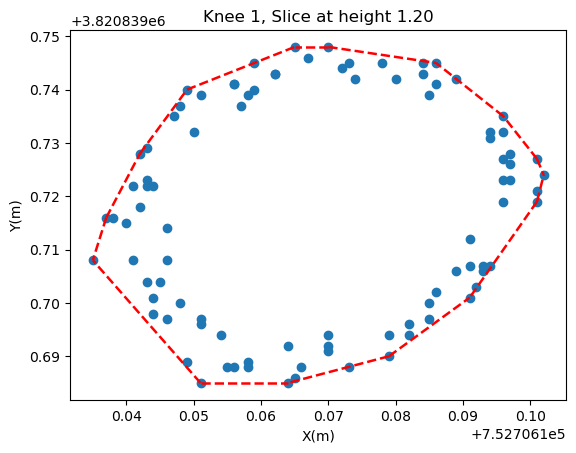

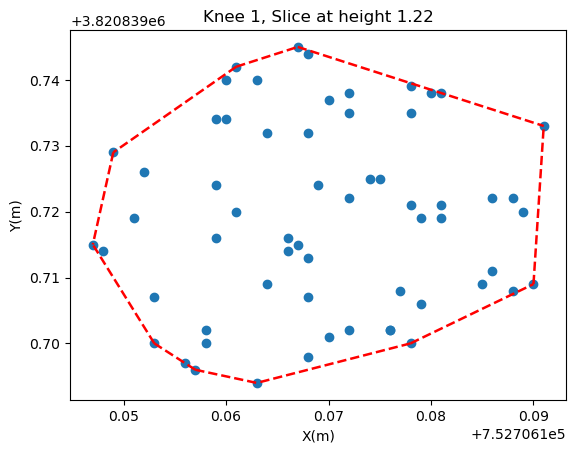

Cluster 1, Slicing Height cluster_volume: 0.01636 cubic units


In [18]:
# Function to calculate volume for a given slicing height
def calculate_volume(labels, x, y, z, num_clusters, slice_height):
    # Store the cluster volumes
    cluster_volumes = []
    result = []
    columns = ['Cluster', 'Slicing Height', 'Volume']

    # Loop over the clusters
    for i in range(num_clusters):
        # Get the points belonging to this cluster
        cluster_points = np.where(labels == i)[0]

        # Calculate the convex hull of the cluster
        cluster_hull = ConvexHull(np.column_stack((x[cluster_points], y[cluster_points], z[cluster_points])))
        
        # Calculate the volume of the cluster without slicing
        cluster_volume = cluster_hull.volume
        cluster_volumes.append(cluster_volume)
        
        # Get the minimum and maximum z coordinates of the cluster
        min_z = np.min(z[cluster_points])
        max_z = np.max(z[cluster_points])

        # Create a list of slicing heights
        slice_heights = np.arange(min_z, max_z + slice_height, slice_height)

        # Initialize the volume and last_area
        volume = 0.0
        last_area = 0.0

        # Slice the convex hull at each slicing height
        for j in range(len(slice_heights) - 1):
            # Select the points within the slicing height
            mask = (cluster_hull.points[:, 2] >= slice_heights[j]) & (cluster_hull.points[:, 2] < slice_heights[j+1])
            points = cluster_hull.points[mask, :2]

            # Check if there are enough points to compute the convex hull
            if len(points) < 3:
                continue

            # Calculate the area of the slice
            area = ConvexHull(points).volume

            # Integrate the area to calculate the volume of this slice
            slice_volume = slice_height * (area + last_area) / 2

            volume += slice_volume

            # Save the current area for the next iteration
            last_area = area

            # Plot the slice and its convex hull
            hull = ConvexHull(points)
            plt.plot(points[:, 0], points[:, 1], 'o')
            for simplex in hull.simplices:
                plt.plot(points[simplex, 0], points[simplex, 1], 'r--', lw=1.8)
            #plt.title(f"Slice at height {slice_heights[j]:.2f}")
            plt.title(f"Knee {i+1}, Slice at height {slice_heights[j]:.2f}")
            #plt.title(f"Knee {i+1}, Slice {j+1}")
            plt.xlabel("X(m)")
            plt.ylabel("Y(m)")
            plt.show()

            # Append the results for this cluster and slicing height
            result.append([i+1, slice_height, volume])

    # Print the volume of each cluster for the "cluster_volume" slicing height
    for i, volume in enumerate(cluster_volumes):
        print(f"Cluster {i+1}, Slicing Height cluster_volume: {volume:.5f} cubic units")

    return pd.DataFrame(result, columns=columns)

# Calculate volume for each slicing height
slicing_heights = [0.2, 0.1, 0.05, "cluster_volume", 0.02]
cluster_volumes = calculate_volume(labels, x, y, z, num_clusters, slicing_heights[-1])

# Use the calculated cluster volumes for the "cluster_volume" slicing height
slicing_heights[-2] = cluster_volumes['Volume']

# Results in tabular form
#result_table = pd.concat([calculate_volume(labels, x, y, z, num_clusters, slicing_height) for slicing_height in slicing_heights], ignore_index=True)
#print(result_table)

##### Calculate the properties of each knees clusters (i.e. the height and the diameter)

In [19]:
# Loop over the clusters
for i in range(num_clusters):
    # Get the points belonging to this cluster
    cluster_points = np.where(labels == i)[0]
    
    # Calculate the height of the cluster
    min_z = np.min(z[cluster_points])
    max_z = np.max(z[cluster_points])
    height = max_z - min_z

    # Calculate the convex hull of the cluster
    cluster_hull = ConvexHull(np.column_stack((x[cluster_points], y[cluster_points], z[cluster_points])))

    # Calculate the diameter of the cluster
    max_distance = 0
    for simplex in cluster_hull.simplices:
        dist = np.linalg.norm(cluster_hull.points[simplex[0]] - cluster_hull.points[simplex[1]])
        if dist > max_distance:
            max_distance = dist
    diameter = max_distance

    # Print the properties of this cluster
    #print(f"Knee {i+1}:")
    print(f"Height {i+1}: {height:.4f}")
    print(f"Diameter {i+1}: {diameter:.2f}")
    print("")

    '''
    # Plot the cluster
    fig = plt.figure(figsize=(5,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x[cluster_points], y[cluster_points], z[cluster_points], c=np.vstack((r[cluster_points], g[cluster_points], b[cluster_points])).T, marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()
    '''

Height 1: 0.8390
Diameter 1: 0.79

